In [6]:
import librosa
#使用sf读取wav文件
import soundfile as sf
# 指定要读取的wav文件路径
file_path = './examples/default.wav'
# 使用soundfile库读取wav文件
data, samplerate = sf.read(file_path)
resampled_audio = librosa.resample(data, orig_sr=24000, target_sr=44000)

In [7]:
len(data)

199228

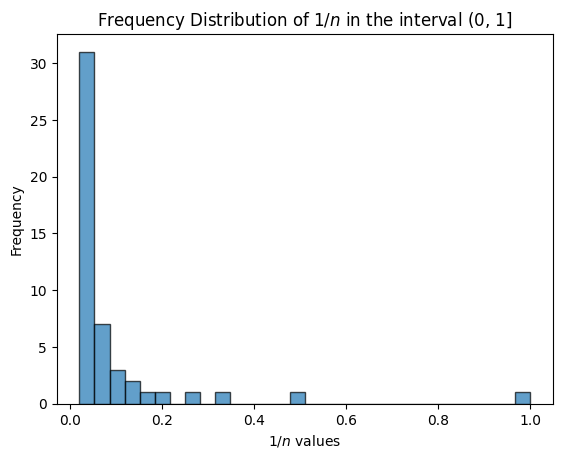

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# 生成 n 的值，这里选择 1 到 1000 之间的整数
n_values = np.arange(1, 50)

# 计算 1/n 的值
inv_n_values = 1 / n_values

# 绘制频率分布直方图
plt.hist(inv_n_values, bins=30, edgecolor='black', alpha=0.7)

# 设置标题和标签
plt.title('Frequency Distribution of $1/n$ in the interval (0, 1]')
plt.xlabel('$1/n$ values')
plt.ylabel('Frequency')

# 显示图形
plt.show()


In [5]:
import requests
import base64
import numpy as np
import librosa
import soundfile as sf

# 定义请求的URL
url = "http://172.28.4.43:80/v1/tts"

# 定义请求的数据
request_data = {
    "text": "而你，我的朋友，你是真正的英雄",
    "voice_name": "default",
    "language": "zh"
}

# 发送POST请求
response = requests.post(url, json=request_data)
import torchaudio
import torch
# 检查响应状态码
if response.status_code == 200:
    # 从响应中提取Base64编码的音频数据
    response_data = response.json()
    data = response_data.get("audio")
    data = np.frombuffer(base64.b64decode(data), dtype=np.float32)
    torchaudio.save('output.wav', torch.tensor(data).unsqueeze(0), 24000)
else:
    print(f"请求失败，状态码：{response.status_code}")
    print("响应内容：", response.text)

In [8]:
import asyncio
import websockets
import json
import base64
import numpy as np
import librosa
import torch
import torchaudio
import soundfile as sf
import nest_asyncio
nest_asyncio.apply()

async def receive_audio_data(uri):
    async with websockets.connect(uri) as websocket:
        # 发送配置消息
        config_message = json.dumps({
            "language": "zh",
            "voice_name": "default",
            "sample_rate": 16000,
            "channel": 1,
            "format": "pcm",
            "bits": 16
        })
        await websocket.send(config_message)

        # 接收确认消息
        response = await websocket.recv()
        print("Config response:", response)

        # 发送文本消息
        text_message = json.dumps({"text": "在小小的花园里面挖呀挖呀挖"})
        await websocket.send(text_message)

        audio_data_list = []

        while True:
            try:
                # 接收数据
                message = await websocket.recv()
                response = json.loads(message)
                seq = response.get("audio_block_seq")
                audio_status = response.get("audio_status")
                base64_audio_data = response.get("data")
                # 解码Base64字符串
                audio_data = base64.b64decode(base64_audio_data)
                # 仅在audio_status不为2时处理音频数据
                # 将解码后的二进制数据转换为NumPy数组
                audio_array = np.frombuffer(audio_data, dtype=np.float32)
                audio_data_list.append(torch.tensor(audio_array))
                if audio_status == 2:
                    break
                '''
                if audio_status == 2 or seq == 0:
                    if audio_status == 2:
                        break
                    else:
                        continue
                else:
                    # 解码Base64字符串
                    audio_data = base64.b64decode(base64_audio_data)
                    # 仅在audio_status不为2时处理音频数据
                    # 将解码后的二进制数据转换为NumPy数组
                    audio_array = np.frombuffer(audio_data, dtype=np.float32)
                    audio_data_list.append(torch.tensor(audio_array))
                '''
            except websockets.exceptions.ConnectionClosed:
                print("Connection closed")
                break
        result = torch.cat(audio_data_list)
        torchaudio.save('output_stream_24000.wav', result.unsqueeze(0), 24000)
        print("音频文件已保存为output.wav")

asyncio.get_event_loop().run_until_complete(receive_audio_data("ws://172.28.4.43:80/stream/tts"))


Config response: {"success": true}


音频文件已保存为output.wav


In [3]:
import requests
import base64
import soundfile as sf
import json

# 读取示例音频文件并编码为Base64
def read_audio_file(file_path):
    with open(file_path, "rb") as audio_file:
        audio_bytes = audio_file.read()
    audio_base64 = base64.b64encode(audio_bytes).decode("utf-8")
    return audio_base64

# 准备请求数据
audio_file_path = "./examples/default.wav"
audio_base64 = read_audio_file(audio_file_path)
voice_name = "test_voice"

# 构建请求数据
request_data = {
    "audios": {
        "audio_bytes": audio_base64,
        "audio_format": "wav"
    },
    "voice_name": voice_name
}

# 发送POST请求
url = "http://172.28.4.43:80/internal/v1/voice-clone"
response = requests.post(url, json=request_data)

# 打印响应
print("Status Code:", response.status_code)
print("Response JSON:", response.json())

Status Code: 200
Response JSON: {'voice_name': 'test_voice', 'status': 2}
